In [4]:
import os
import dask.dataframe as dd
import datetime as dt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [5]:
#Ouverture des bases de données
df_cct = pd.read_parquet("/home/onyxia/work/cct.parquet")


In [6]:
#Un peu de nettoyage

df_cct["Amount"] = df_cct["Amount"].str.replace("$","")
df_cct["Amount"] = df_cct["Amount"].astype(float)
df_cct["Is Fraud?"].mask(df_cct["Is Fraud?"] == "Yes", 1 , inplace = True)
df_cct["Is Fraud?"].mask(df_cct["Is Fraud?"] == "No", 0 , inplace = True)

In [7]:
df_fraud = df_cct[df_cct["Is Fraud?"] == 1]

In [8]:
df_not_fraud = df_cct[df_cct["Is Fraud?"] == 0]

## I. Time intervals between transactions

In [9]:
#Création des variables 'timestamp', 'delta_t_s' et 'delta_t_s_card'
def time(dataframe):
   dataframe[['Hours', 'Minutes']] = dataframe.Time.str.split(":", n=1, expand=True) #scinder la colonne Time en 2
   dataframe["Hours"] = dataframe["Hours"].astype(int)
   dataframe["Minutes"] = dataframe["Minutes"].astype(int)
   #Créer une colonne 'Timestamp' : format année, mois, jour, heure, minute:
   timestamp = pd.to_datetime(dataframe[["Year",'Month','Day','Hours','Minutes']], format = '%Y:%M:%D%:%H:%M')
   date = pd.to_datetime(dataframe[["Year",'Month','Day']], format = '%Y:%M:%D%')
   dataframe["date"] = date.values
   dataframe["timestamp"] = timestamp.values
   dataframe["delta_t_card"] = (timestamp-timestamp.shift()) #calculer l'intervalle de temps entre
   #deux transactions de la même carte et du même user

   #Convertir delta_t_card en secondes et mettre à 0 les temps négatifs 
   #(ici, dataframe ordonné en fonction de l'user et de la carte, et non de la chronologie):
   dataframe["delta_t_s_card"] = dataframe["delta_t_card"].dt.total_seconds().fillna(0).astype(int)
   dataframe["delta_t_s_card"] = dataframe["delta_t_s_card"].mask(dataframe["delta_t_s_card"] < 0, 0)

   #Réordonner les transactions en fonction du User et de la chronoogie de ses transactions : 
   dataframe = dataframe.sort_values(["User", "Year","Month","Day","Hours","Minutes"], ascending=[True,True,True,True,True,True]).reset_index(drop=True)
   timestamp2 = pd.to_datetime(dataframe[["Year",'Month','Day','Hours','Minutes']], format = '%Y:%M:%D%:%H:%M')
   dataframe['delta_t'] = (timestamp2-timestamp2.shift()) #différence de temps entre deux transactions du même user
   dataframe["delta_t_s"] = dataframe["delta_t"].dt.total_seconds().fillna(0).astype(int) #pour la première
   #transaction, fixer le delta_t_s à 0
   dataframe["delta_t_s"] = dataframe["delta_t_s"].mask(dataframe["delta_t_s"] < 0, 0)

   dataframe = dataframe[['User', 'Card', 'date', 'timestamp', 'Hours', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'delta_t_s','delta_t_s_card','Is Fraud?']] #ordonner et sélectionner les colonnes
   
   return dataframe



In [10]:
df_cct = time(df_cct)

In [11]:
df_cct["delta_t_s"].mean() #average time between two transactions ~ 8 hours

29590.274720444173

In [12]:
df_cct["delta_t_s"].median() #average time between two transactions ~ 8 hours

13920.0

In [13]:
import matplotlib.pyplot as plt

In [14]:
df_cct["delta_t_s"].max()

417268260

In [15]:
df_cct_1 = df_cct[df_cct["delta_t_s"]> 0]

(array([3.086000e+05, 0.000000e+00, 2.915790e+05, 2.740620e+05,
        2.594970e+05, 4.771800e+05, 6.215540e+05, 5.279580e+05,
        7.102860e+05, 6.577690e+05, 8.079690e+05, 8.532110e+05,
        1.025814e+06, 9.749750e+05, 1.026072e+06, 1.263186e+06,
        1.509489e+06, 1.629968e+06, 1.690924e+06, 1.619795e+06,
        1.747675e+06, 2.010328e+06, 2.116032e+06, 1.133782e+06,
        3.281370e+05, 2.432940e+05, 8.206600e+04, 2.454200e+04,
        7.379000e+03, 1.466000e+03, 2.600000e+02, 9.300000e+01,
        6.300000e+01, 6.000000e+01, 6.600000e+01, 6.800000e+01,
        5.600000e+01, 7.300000e+01, 6.300000e+01, 5.300000e+01,
        7.100000e+01, 4.600000e+01, 2.500000e+01, 1.400000e+01,
        1.300000e+01, 1.900000e+01, 1.100000e+01, 1.300000e+01,
        1.200000e+01, 7.000000e+00]),
 array([1.77815125, 1.91499653, 2.05184181, 2.1886871 , 2.32553238,
        2.46237766, 2.59922294, 2.73606822, 2.87291351, 3.00975879,
        3.14660407, 3.28344935, 3.42029463, 3.55713992, 3.

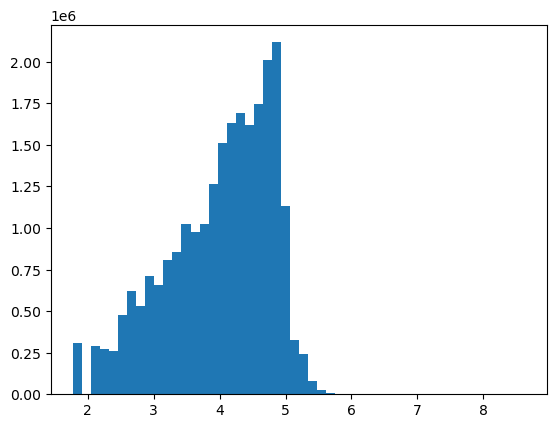

In [16]:
import numpy as np
plt.hist(np.log(df_cct_1["delta_t_s"].to_numpy())/np.log(10),bins=50) #plot distribution of time intervals
#abscisse : log10 time_interval_in_seconds

In [17]:
df_cct["delta_t_s_card"].mean()  #average time between two transactions of same card ~ 18 hourspo

65925.91032726587

## II. Ratio amount of transaction over daily income

In [18]:
import numpy as np

In [19]:
df_users = pd.read_csv("/home/onyxia/work/sd254_users.csv")
df_users['Yearly Income - Person'] = df_users['Yearly Income - Person'].str.replace("$","")
df_users["day_income"] = df_users['Yearly Income - Person'].astype(np.int)/365
df_users.reset_index(inplace=True)
df_users.rename(columns={"index":"User"},inplace=True)
df_cct["amt/day_income"] = df_cct["Amount"]/pd.merge(df_cct,df_users[["User","day_income"]], on="User",how="left")["day_income"]


## III. Daily amount

In [20]:
def calc_rolling_sum(dataf, column=None, setting='1D'):
    return (dataf
            .groupby('User')[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).sum())) #absolute sum of amounts

In [21]:
df_cct["abs_amount"] = df_cct["Amount"].abs() #absolute value of transaction's amount

In [22]:
df_cct["daily_amount"] = (df_cct
.set_index('date')
.assign(daily_amount=lambda d: calc_rolling_sum(d, column='abs_amount')))["daily_amount"].values

## IV. Daily number of declines per card

In [23]:
def calc_rolling_decline(dataf, column=None, setting='1D'):
    return (dataf
        .groupby(['User',"Card"])[column]
        .transform(lambda d: d.rolling(setting, min_periods=1).count()))

In [24]:
df_cct["nb_daily_declines_card"] = (df_cct
.set_index('date')
.assign(nb_daily_declines_card=lambda d: calc_rolling_decline(d, column="Errors?")))["nb_daily_declines_card"].values

## V. Bad_pin

In [25]:
bad_pin = ['Bad PIN','Bad PIN,Insufficient Balance','Bad PIN,Technical Glitch']

In [26]:
df_cct["bad_pin"] = df_cct["Errors?"].apply(lambda x: 1 if x in bad_pin else 0)

## VI. Insufficient balance

In [27]:
insufficient_balance = ['Insufficient Balance','Bad PIN,Insufficient Balance',
'Insufficient Balance,Technical Glitch','Bad Card Number,Insufficient Balance',
'Bad CVV,Insufficient Balance','Bad Expiration,Insufficient Balance',
'Bad Zipcode,Insufficient Balance','Bad Card Number,Bad Expiration,Insufficient Balance']

In [28]:
df_cct["insufficient_balance"] = df_cct["Errors?"].apply(lambda x: 1 if x in insufficient_balance else 0)

## VII. Ratio Number of transaction per hour over average number of transactions per hour during the last 30 days

In [29]:
def calc_rolling_nbt_h(dataf, column=None, setting='1H'):
    return (dataf
            .groupby(['User','Card'])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).count()))

In [30]:
df_cct["hourly_nbt"] = (df_cct
.set_index('timestamp')
.assign(hourly_nbt=lambda d: calc_rolling_nbt_h(d, column= "Amount")))["hourly_nbt"].values

In [31]:
def calc_rolling_av_30d_nbt(dataf, column=None, setting='30D'):
    return (dataf
            .groupby(['User','Card'])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).mean()))

In [32]:
df_cct["last_30_days_av_hourly_nbt"] = (df_cct
.set_index('timestamp')
.assign(last_30_days_av_hourly_nbt=lambda d: calc_rolling_av_30d_nbt(d, column= "hourly_nbt")))["last_30_days_av_hourly_nbt"].values

In [33]:
df_cct["hr_nbt/last_30d_av_hr_nbt"] = df_cct["hourly_nbt"]/df_cct["last_30_days_av_hourly_nbt"]

## VIII. Number of transactions per card for the last 18hr

In [34]:
def calc_rolling_18h_nbt(dataf, column=None, setting='18H'):
    return (dataf
            .groupby(['User','Card'])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).count()))

In [35]:
df_cct["last_18h_nbt"] = (df_cct
.set_index('timestamp')
.assign(last_18h_nbt=lambda d: calc_rolling_18h_nbt(d, column= "Amount")))["last_18h_nbt"].values

## IX. Ratio number of transactions over total amount of transactions for the 3 last days

In [36]:
def calc_rolling_3d_nbt(dataf, column=None, setting='3D'):
    return (dataf
            .groupby(['User','Card'])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).count()))

In [37]:
df_cct["last_3d_nbt"] = (df_cct
.set_index('date')
.assign(last_3d_nbt=lambda d: calc_rolling_3d_nbt(d, column= "Amount")))["last_3d_nbt"].values

In [38]:
def calc_rolling_3d_sum(dataf, column=None, setting='3D'):
    return (dataf
            .groupby(['User',"Card"])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).sum())) 

In [39]:
df_cct["last_3d_amt"] = (df_cct
.set_index('date')
.assign(last_3d_amt=lambda d: calc_rolling_3d_sum(d, column='abs_amount')))["last_3d_amt"].values

In [40]:
df_cct["last_3d_nbt/amt"] = df_cct["last_3d_nbt"]/df_cct["last_3d_amt"]


## X. Final

In [41]:
df_cct_final = df_cct[['User', 'Card', 'Hours', 'Amount', 'Use Chip', 'Merchant State', 'MCC',
       'delta_t_s', 'delta_t_s_card', 'amt/day_income',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin', 'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt',
       'last_18h_nbt','Is Fraud?']] #selecting final features to be used for ML models

In [42]:
df_cct_final

,User,Card,Hours,Amount,Use Chip,Merchant State,MCC,delta_t_s,delta_t_s_card,amt/day_income,daily_amount,nb_daily_declines_card,bad_pin,insufficient_balance,hr_nbt/last_30d_av_hr_nbt,last_18h_nbt,Is Fraud?
0,0,0,6,134.09,Swipe Transaction,CA,5300,0,0,0.819868,134.09,0.0,0,0,1.000000,1.0,0
1,0,0,6,38.48,Swipe Transaction,CA,5411,1260,1260,0.235279,172.57,0.0,0,0,1.333333,2.0,0
2,0,0,6,120.34,Swipe Transaction,CA,5411,85200,85200,0.735796,120.34,0.0,0,0,0.750000,1.0,0
3,0,0,17,128.95,Swipe Transaction,CA,5651,40980,40980,0.788441,249.29,0.0,0,0,0.800000,2.0,0
4,0,0,6,104.71,Swipe Transaction,CA,5912,45480,45480,0.640230,104.71,0.0,0,0,0.833333,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,22,-54.00,Chip Transaction,NH,5541,300,300,-0.299049,369.71,0.0,0,0,1.610738,7.0,0
24386896,1999,1,22,54.00,Chip Transaction,NH,5541,60,60,0.299049,423.71,0.0,0,0,2.388158,8.0,0
24386897,1999,1,7,59.15,Chip Transaction,NH,4121,33540,33540,0.327569,59.15,0.0,0,0,0.796053,6.0,0
24386898,1999,1,20,43.12,Chip Transaction,NH,4121,44820,44820,0.238796,102.27,0.0,0,0,0.794702,2.0,0


In [43]:
df_cct_final.to_parquet("/home/onyxia/work/cct_final.parquet")